In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmdstanpy
from scipy.optimize import minimize
from IPython.display import Image
import arviz as az
import seaborn as sns
from scipy.stats import norm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (11, 7)

# Bayesian linear regression

### Likelihood (preferred notation):
\begin{align}
    y_i \sim \mathcal{N}(\mu_i, \sigma) \\
    \mu_i = \alpha + \beta \, x_i \\
\end{align}
### or:
\begin{align}
    y_i = \mu_i + \epsilon_i \\
    \epsilon_i \sim \mathcal{N}(0, \sigma) \\
\end{align}

### Priors:
\begin{align}
    \alpha \sim \mathcal{N}(0, 1) \\
    \beta \sim \mathcal{N}(0, 1) \\
    \sigma \sim Exp\,(1) \\
\end{align}

# how to read graphical models

## grey filled in circles = things i observe

## white circles = parameters

## arrows = generates. e.g., mu_i and sigma point to y_i. can think of this as mu_i and sigma generating y_i (in this case, under a gaussian model)

## unfortunately the arrows don't tell you what the relationships are, they just tell you that there IS one

## rectangle = "plate". used for repeated observations. can be nested if you have groups within groups

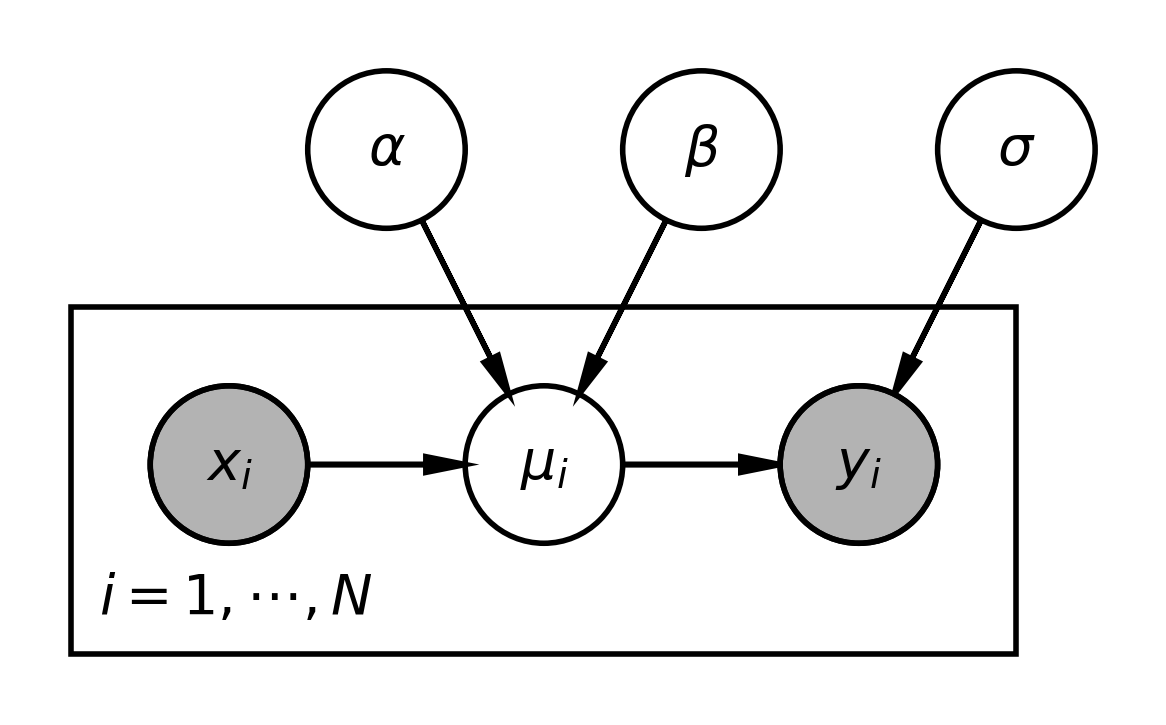

In [3]:
Image("pgm.png", embed=True, width=800, height=700)

Text(0, 0.5, 'y')

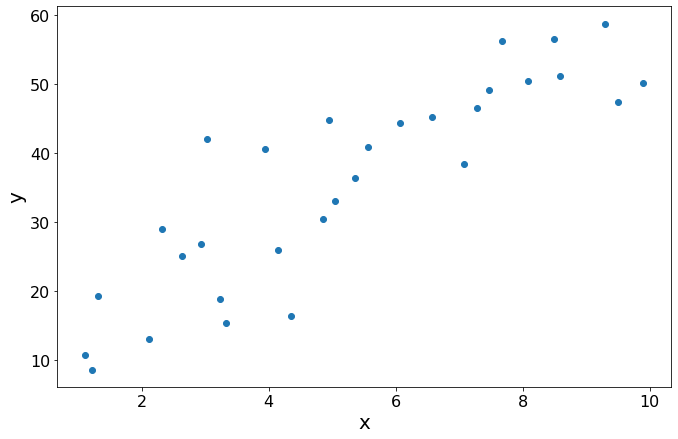

In [4]:
# generate some data
n = 30
x = np.random.choice(np.linspace(0, 10, 100), size=n, replace=False)
x = np.sort(x)

# true values that we want to recover
a = 10
b = 5
s = 7

# simulate some observations
mu = a + b * x
y = np.random.normal(mu, s)

# clamp at 0, maybe y is something physical that can't be negative (e.g. weight, height)
y = np.maximum(y, 0)

# plot the data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

# mle, MAP, likelihoods

### Gaussian likelihood:

\begin{align}
    f(y | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \, \exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right)
\end{align}

In our case, since we are defining $\mu = mx + b$, we can rewrite our likelihood as
\begin{align}
    f(y | x, m, b, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \, \exp\left(-\frac{(y - (mx + b))^2}{2\sigma^2}\right)
\end{align}

For $i = 1 \cdots N$, $y_i \sim N(\mu_i, \sigma)$. Assuming the $y_i$'s are **iid**, multiply all the likelihoods:

\begin{align}
    f(y_1, \cdots, y_n | x_1, \cdots, x_n, m, b, \sigma) = \prod_{i = 1}^{N} f(y_i | x_i, m, b, \sigma)
\end{align}

In practice, we tend to use **log likelihoods** for simplicity and stability. Since log is a strictly increasing function, maximizing the likelihood is the same as maximizing the log likelihood. The log likelihood is:

\begin{align}
    \mathcal{L} = -\frac{n}{2} \ln(2 \pi \sigma^2) - \frac{\sum_{i=1}^{N} (y_i - (mx_i + b))^2}{2 \sigma^2}
\end{align}

In [5]:
def ln_likelihood(theta: (float, float, float), x: np.ndarray, y: np.ndarray) -> float:
    assert x.size == y.size
    n = x.size
    b, m, sigma = theta
    mu = m * x + b
    return -n / 2 * np.log(2 * np.pi * sigma**2) - np.sum((y - mu)**2) / (2 * sigma**2)

# some comments on gradients, bfgs, and hessians

## mle is basically an optimization problem. i want to maximize the likelihood. i take the (partial) derivatives of the likelihood function with respect to each of the parameters, and find the values for each parameter that make the gradients zero.

## numerically, this can be done with a minimizer. instead of maximizing the likelihood, i minimize the negative likelihood. this basically starts somewhere in parameter space, calculates the gradient at that location, then takes a step in the direction that gets you closer to the minimum. at that new location the gradients are hopefully smaller. 

## play around with the "maxiter" parameter below (how many steps to take) and see how the "jac" (jacobian, which is a vector of the partial derivatives) changes

## the uncertainty on the estimates can be quantified using the "hessian" (matrix of second derivatives), with some caveats. 

## 1) this assumes gaussian errors, which is unlikely to be the case.
## 2) we would like an exact hessian but because we are using a quasi-newton algorithm to minimize (BFGS), we only get the approximate hessian. 

In [59]:
nll = lambda *args: -ln_likelihood(*args)
guess = (1, 1, 1)
theta = minimize(nll, guess, args=(x, y), options=dict(maxiter=50))
theta

      fun: 101.43752791456446
 hess_inv: array([[ 7.42640352e+00, -1.12547167e+00, -1.00369992e-02],
       [-1.12547167e+00,  2.19683921e-01,  1.60726630e-03],
       [-1.00369992e-02,  1.60726630e-03,  8.24053090e-01]])
      jac: array([ 2.86102295e-06, -6.67572021e-06,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 164
      nit: 34
     njev: 41
   status: 0
  success: True
        x: array([9.89526097, 4.92460241, 7.11576343])

In [7]:
mle_params = theta.x
errs = np.sqrt(np.diag(theta.hess_inv))
mle_params, errs

(array([9.89526097, 4.92460241, 7.11576343]),
 array([2.72514284, 0.46870451, 0.9077737 ]))

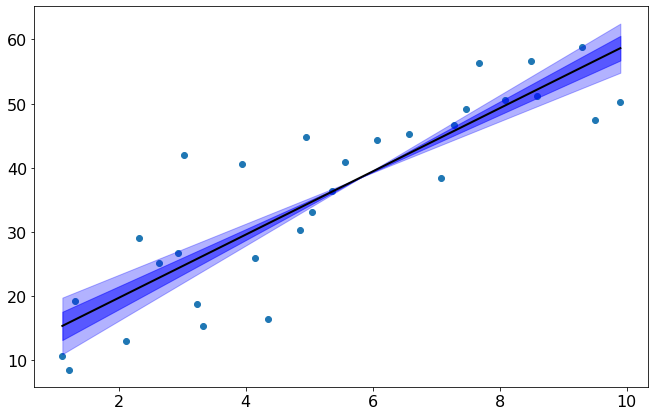

In [8]:
plt.scatter(x, y)
plt.plot(x, x * mle_params[1] + mle_params[0], c='k', lw=2, zorder=5)
plt.fill_between(x,  x * (mle_params[1] - errs[1]) + (mle_params[0] + errs[0]),  x * (mle_params[1] + errs[1]) + (mle_params[0] - errs[0]), color='b', alpha=0.5)
plt.fill_between(x,  x * (mle_params[1] - 2 * errs[1]) + (mle_params[0] + 2 * errs[0]),  x * (mle_params[1] + 2 * errs[1]) + (mle_params[0] - 2 * errs[0]), color='b', alpha=0.3)

# choosing priors: "prior predictive checks", draw random samples from some proposal prior, make predictions using those samples. see if they are reasonable compared to the data

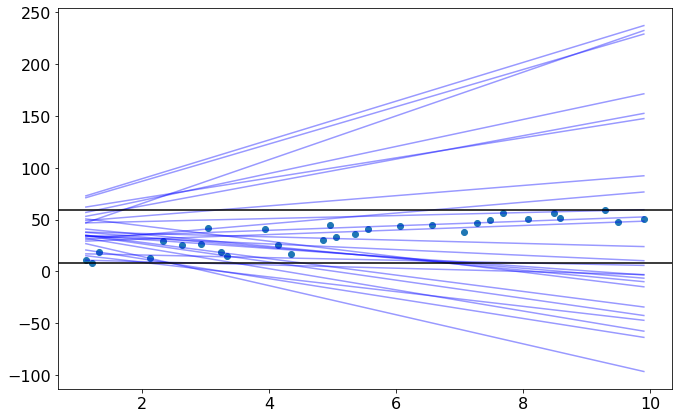

In [9]:

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.normal(0, 10, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.4)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

# Some of the possibilities are completely unreasonable (either way outside the range of what we observe or unphysical). We also put equal probability on positive and negative slopes (with zero slope meaning that there is no relationship between x and y). We should probably pick better priors!

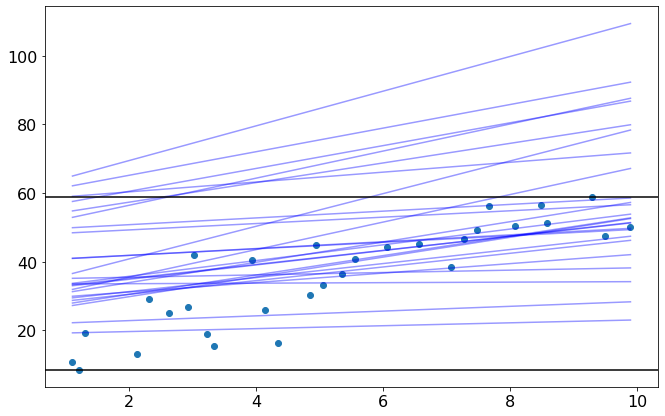

In [10]:
# see if our priors are reasonable

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.lognormal(0.1, 1, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.4)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

# markov chain monte carlo (mcmc): engine for bayesian inference

# big idea: you give me a probability distribution, i give you samples drawn from that distribution. we use this to sample from the posterior

# see https://chi-feng.github.io/mcmc-demo/app.html for visualizations of different mcmc algorithms. for high dimensional problems with continuous parameters i highly recommend NUTS.

# Random walk Metropolis: start at a random spot, make a proposal to move somewhere around your current positions, move to the new position with some probability proportional to the density at the new location over the density at the current position. 

## fun exercise: write your own random walk Metropolis code! https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

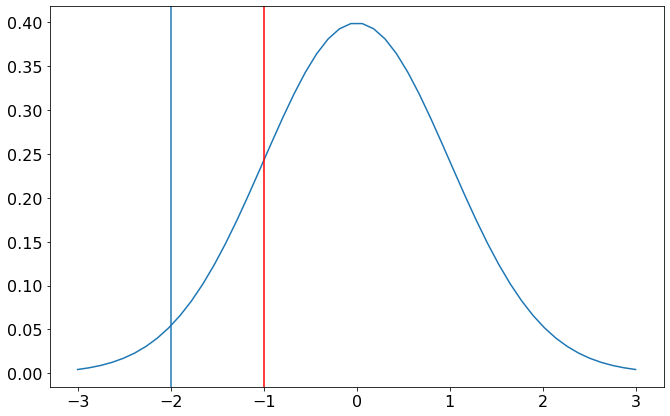

In [16]:
xr = np.linspace(-3, 3)
yr = norm.pdf(xr)
plt.plot(xr, yr)
plt.axvline(-2)
plt.axvline(-1, c='r')

# compile a stan model below (uses the NUTS algorithm). there are two included versions, one has priors that we chose above, another uses flat priors (to show MAP and MLE)

In [72]:
sm = cmdstanpy.CmdStanModel(stan_file = 'linreg-flat.stan') # one with non-flat priors is linreg.stan

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/js/programs/linreg-bayes/linreg-flat


In [73]:
# prep data to be passed in to stan model
data = {
    'N': n,
    'x': x,
    'y': y,
}

In [74]:
# sample posterior
fit = sm.sample(data, chains=2, show_progress='notebook')

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
# get posterior samples
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
sigmas = fit.stan_variable('sigma')

# compare to mle estimates

# mle estimates are the mode of the posterior distributions IF you use flat priors on all your parameters (because the priors will all end up being constant, so your posterior will be proportional to your likelihood, so the mode of the likelihood is the mode of the posterior). called "MAP" (maximum a posterior)

# if not using flat priors, mle won't be the same as mode of posterior.

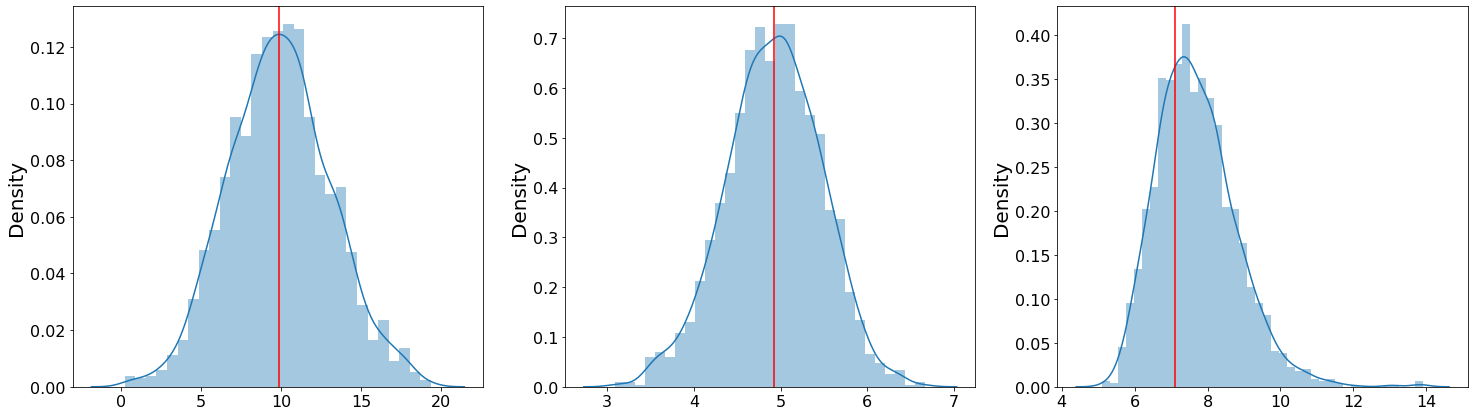

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

sns.distplot(alphas, ax=ax[0])
sns.distplot(betas, ax=ax[1])
sns.distplot(sigmas, ax=ax[2])

# ax[0].hist(alphas)
# ax[1].hist(betas)
# ax[2].hist(sigmas)

ax[0].axvline(mle_params[0], c='r')
ax[1].axvline(mle_params[1], c='r')
ax[2].axvline(mle_params[2], c='r')


# along the diagonals: "marginal distributions", high dimensional posterior integrated along every axis other than the axis of your parameter, basically tells you the "overall" distribution of the parameter

# lower diagonal panels: "joint distributions" between each pair of parameters. useful for getting information about the correlations between parameters.

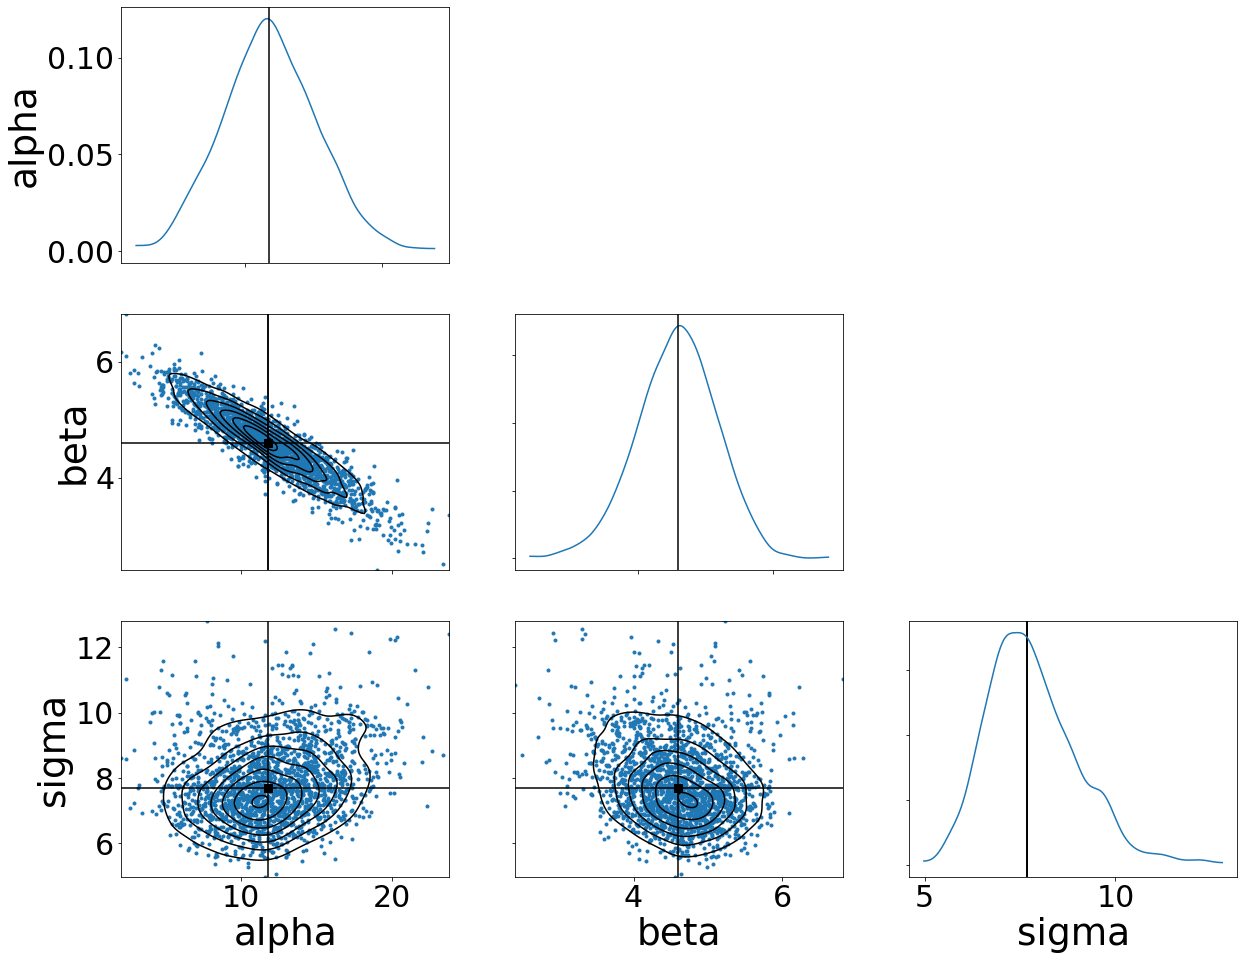

In [30]:
az.plot_pair(fit, var_names=['alpha', 'beta', 'sigma'], marginals=True, kind=['scatter', 'kde'], point_estimate='median', textsize=30, figsize=(20, 16));

# read this: https://corner.readthedocs.io/en/latest/pages/sigmas.html

# sample from posterior, see what the predictions look like

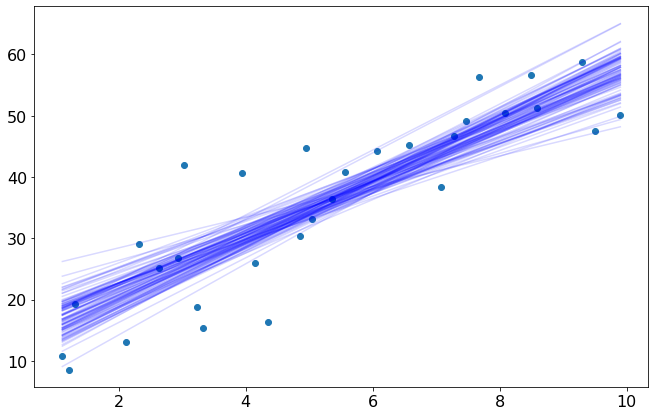

In [32]:
idx = np.random.choice(np.arange(2000), 100, replace=False)

for i in idx:
    plt.plot(x, alphas[i] + betas[i] * x, c='b', alpha=0.15)
    
plt.scatter(x, y)

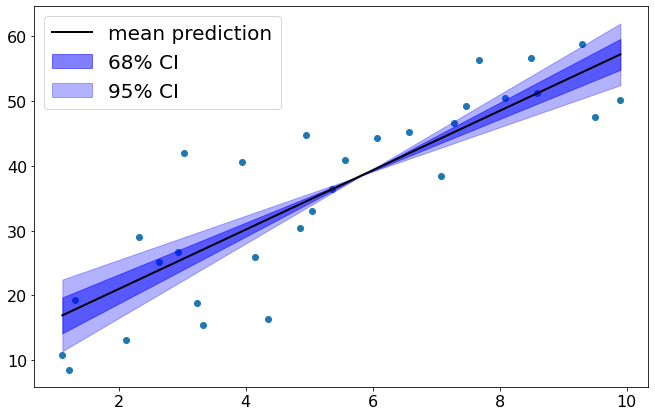

In [33]:
alpha_mean = alphas.mean()
alpha_std = alphas.std()
beta_mean = betas.mean()
beta_std = betas.std()

plt.scatter(x, y)
plt.plot(x, alpha_mean + beta_mean * x, color='k', zorder=5, lw=2, label='mean prediction')
plt.fill_between(x, (alpha_mean - alpha_std) + (beta_mean + beta_std) * x, (alpha_mean + alpha_std) + (beta_mean - beta_std) * x, alpha=0.5, color='b', label='68% CI')
plt.fill_between(x, (alpha_mean - 2 * alpha_std) + (beta_mean + 2 * beta_std) * x, (alpha_mean + 2 * alpha_std) + (beta_mean - 2 * beta_std) * x, alpha=0.3, color='b', label='95% CI')
plt.legend(fontsize=20)

# simulating fake data "posterior predictive checks"

# big idea: if your model is good (enough), then you should be able to simulate data that looks like the real data

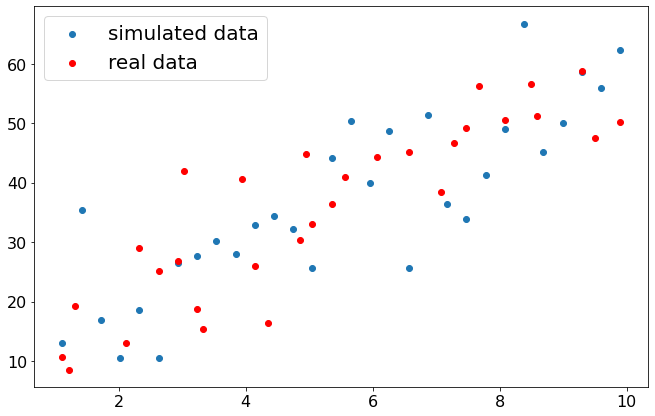

In [34]:
idx = np.random.choice(np.arange(2000), n)

x_psim = np.linspace(x.min(), x.max(), n)
mu_psim = alphas[idx] + betas[idx] * x_psim
y_psim = np.random.normal(mu_psim, sigmas[idx])

plt.scatter(x_psim, y_psim, label='simulated data')
plt.scatter(x, y, c='r', label='real data')
plt.legend(fontsize=20)

# more checks

<AxesSubplot:ylabel='Density'>

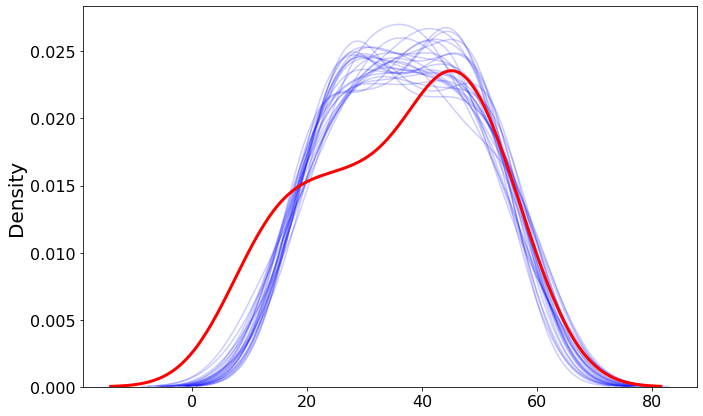

In [35]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.distplot(alphas[idx] + betas[idx] * x_psim, hist=False, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.distplot(y, hist=False, kde_kws=dict(lw=3), color='red')

# "empirical CDF plots" (essentially the integral of a kernel density estimate)

<AxesSubplot:ylabel='Proportion'>

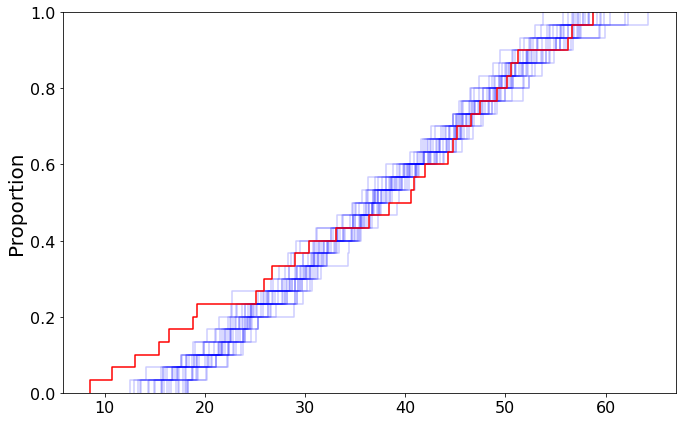

In [36]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.ecdfplot(alphas[idx] + betas[idx] * x_psim, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.ecdfplot(y, color='red')

## simulated data look reasonably similar to the real data -> the model does an adequate job of describing what we see

# what if the model gave us a different posterior distribution?

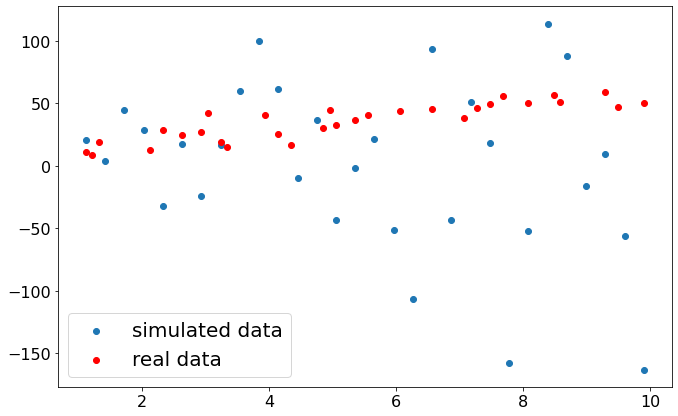

In [37]:
beta_fake = np.random.normal(0, 10, size=2000)



idx = np.random.choice(np.arange(2000), n)

x_psim = np.linspace(x.min(), x.max(), n)
mu_psim = alphas[idx] + beta_fake[idx] * x_psim
y_psim = np.random.normal(mu_psim, sigmas[idx])

plt.scatter(x_psim, y_psim, label='simulated data')
plt.scatter(x, y, c='r', label='real data')
plt.legend(fontsize=20)

<AxesSubplot:ylabel='Density'>

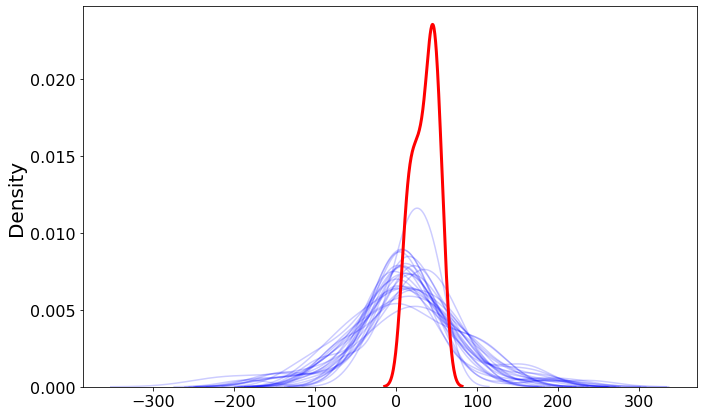

In [38]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.distplot(alphas[idx] + beta_fake[idx] * x, hist_kws=dict(alpha=0.2), hist=False, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.distplot(y, hist=False, kde_kws=dict(lw=3), color='red')

<AxesSubplot:ylabel='Proportion'>

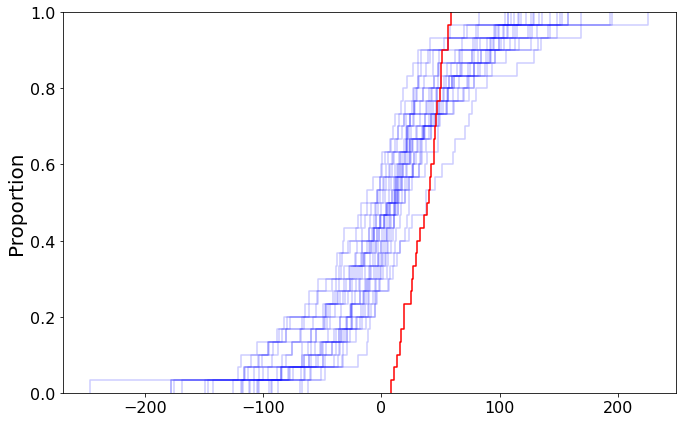

In [39]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.ecdfplot(alphas[idx] + beta_fake[idx] * x_psim, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.ecdfplot(y, color='red')

# model does not do a good job of describing the data -> need to improve the model! looking at what fails can tell you about how to improve your model